In [1]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import scipy
import pickle

import sys
sys.path.append("/home/chrhck/repos/hierarchical_nu/software/")

from python.source.flux_model import FluxModel

from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator)
from python.backend.operations import FunctionCall
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.parameterizations import LogParameterization
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)
import pystan

from python.source.atmospheric_flux import AtmosphericNuMuFlux
import os
from python.cache import Cache
# Cache.clear_cache(dry_run=False)
from astropy import units as u


In [2]:
atmo_flux = AtmosphericNuMuFlux(1E2 * u.GeV, 1E9 * u.GeV)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


/mnt/c/repos/hierarchical_nu/software/python/source/atmospheric_flux.py:144: RuntimeWarning: invalid value encountered in log10
  self._flux_spline = splined_flux


In [3]:
e_true_name = "e_trues"
true_dir_name = "true_dirs"

with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")

    with DataContext() as dc:
        array_length = ForwardVariableDef("n", "int")
        array_length_str = ["[", array_length, "]"]
        
        e_trues = ForwardArrayDef(e_true_name, "real", array_length_str)       
        true_dirs = ForwardArrayDef(true_dir_name, "vector[3]", array_length_str)


    with GeneratedQuantitiesContext() as gq:
        atmo_flux_stan = atmo_flux.make_stan_function()

        array_length_2d_str = ["[", array_length, ",", array_length, "]"]
        atmo_flux_result = ForwardArrayDef("atmo_flux_result", "real", array_length_2d_str)

        with ForLoopContext(1, array_length, "i") as i:
            with ForLoopContext(1, array_length, "j") as j:
                atmo_flux_result[i][j] << atmo_flux_stan(e_trues[i], true_dirs[j])       
               
    model = cg.generate()

In [4]:
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

In [12]:
n = 100
e_reco = np.logspace(2, 9, n)
thetas = np.pi - np.radians(np.linspace(0, 180, n, endpoint=False))
true_dir = np.asarray([np.sin(thetas), np.zeros_like(thetas), np.cos(thetas)]).T

data = {
    e_true_name: e_reco,
    true_dir_name: true_dir,
    "n": n
    #"reco_dir": dir2
}
fit = sm.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")


[]

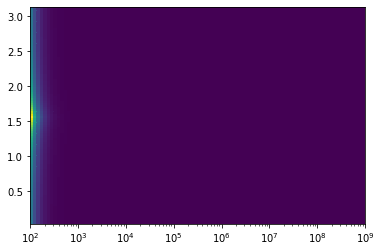

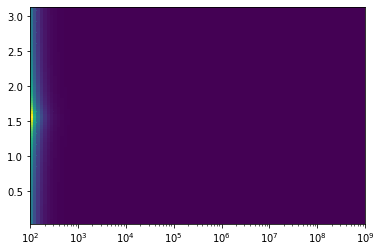

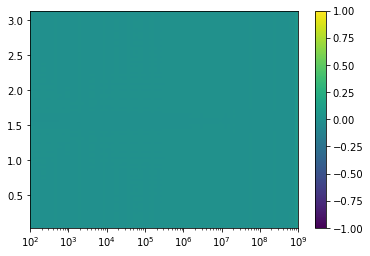

In [13]:
flux_arr = np.empty((n, n))

for i, theta in enumerate(thetas):
    flux_arr[i] = atmo_flux(e_reco * u.GeV, theta * u.rad - np.pi/2 * u.rad, 0 * u.rad)
    
    

plt.pcolormesh(e_reco, thetas, flux_arr)
plt.semilogx()
plt.figure()
plt.pcolormesh(e_reco, thetas, fit.extract()["atmo_flux_result"].squeeze().T)
#plt.plot(e_reco, fit.extract()["atmo_flux_result"].squeeze().T[0]+ 3*np.log10(e_reco))

#energies = np.linspace(1, 9, 100)
#plt.plot(10**energies, atmo_flux.spectrum(10**energies, 0) + 3*energies)
plt.semilogx()
plt.figure()
plt.pcolormesh(e_reco, thetas, np.log10((fit.extract()["atmo_flux_result"].squeeze().T / flux_arr)), vmin=-1, vmax=1)
plt.colorbar()
plt.semilogx()

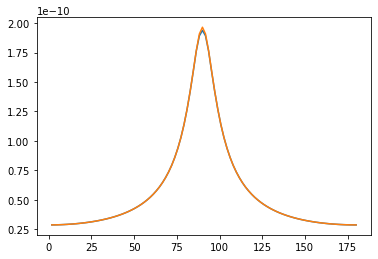

In [14]:
plt.plot(np.degrees(thetas), fit.extract()["atmo_flux_result"].squeeze().T[:,30])
plt.plot(np.degrees(thetas), flux_arr[:,30])


In [8]:
energies = np.linspace(1, 9, 100)
plt.plot(energies, atmo_flux.spectrum(10**energies, 0) + 3*energies)
plt.plot(energies, atmo_flux.spectrum(10**energies, np.pi/4) + 3*energies)
plt.xlabel("log10(Energy / GeV)")
plt.ylabel("E^3 * Flux")
zeniths = np.linspace(-90, 0, 100)
plt.figure()
plt.plot(zeniths, atmo_flux.spectrum(1E5, np.radians(zeniths)) + 3*5)
plt.ylabel("E^3 * Flux @ 100TeV")
plt.xlabel("Declination [deg]")

AttributeError: 'AtmosphericNuMuFlux' object has no attribute 'spectrum'

In [9]:
mceq = MCEqRun(
    # High-energy hadronic interaction model
    interaction_model='SIBYLL23C',

    # cosmic ray flux at the top of the atmosphere
    primary_model = (crf.HillasGaisser2012, 'H3a'),

    # zenith angle
    theta_deg = 0., 
    )

theta = 7
mceq.set_theta_deg(theta)
mceq.solve()
flux = (mceq.get_solution('numu') +
        mceq.get_solution('antinumu'))

e_mask = (mceq.e_grid > 1) & (mceq.e_grid < 1E9)
erange_lim = mceq.e_grid[e_mask]
flux_spline = atmo_flux.spectrum(erange_lim, np.pi/2 -np.radians(theta))


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [10]:
flux_spline = atmo_flux.spectrum(erange_lim, np.pi/2 -np.radians(theta))

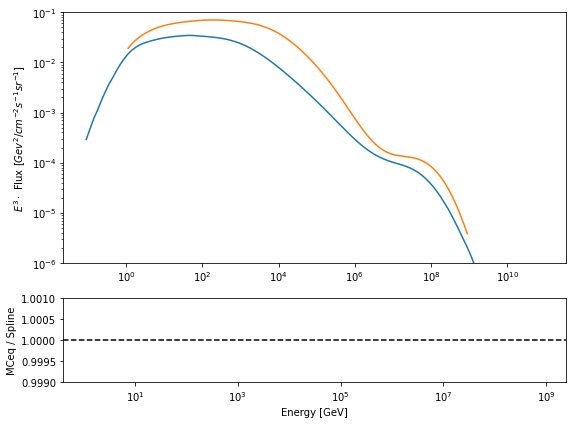

In [11]:
from matplotlib import gridspec as gs

grid = gs.GridSpec(2, 1, height_ratios = [3, 1])
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])

ax1.plot(mceq.e_grid, flux*mceq.e_grid**3)
ax1.plot(erange_lim, 10**flux_spline*erange_lim**3)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.plot(erange_lim, flux[e_mask]/10**flux_spline)

ax2.set_ylim(0.999, 1.001)
ax1.set_ylim(1E-6, 1E-1)
ax2.set_xlabel("Energy [GeV]")
ax1.set_ylabel(r"$E^3 \cdot$ Flux [$ Gev^2/cm^{-2}s^{-1}sr^{-1}]$")
ax2.set_ylabel("MCeq / Spline")
plt.tight_layout()
ax2.axhline(1, ls="--", color="k")


In [8]:
flux_spline = atmo_flux.spectrum(erange_lim, np.pi/2 -np.radians(theta))

[]

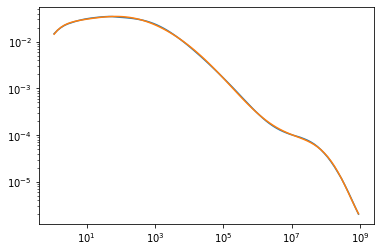

In [16]:
fit = np.polyfit(np.log10(erange_lim), flux_spline, 9)
plt.plot(erange_lim, 10**flux_spline*erange_lim**3)
plt.plot(erange_lim, 10**np.poly1d(fit)(np.log10(erange_lim))*erange_lim**3)
plt.loglog()

In [17]:
np.arccos(1)

0.0

In [4]:
atmo_spectrum = AtmosphericNuMuSpectrum()
from python.source.source import DiffuseZenithDepSource
DiffuseZenithDepSource("atmo", 0, spectral_shape=atmo_spectrum)

TypeError: _set_units() takes 1 positional argument but 4 were given

In [5]:
atmo_spectrum.set_units()

TypeError: set_units() missing 3 required positional arguments: 'in_x_unit', 'in_y_unit', and 'in_z_unit'

TypeError: set_units() missing 1 required positional argument: 'in_z_unit'